In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import ttest_ind, boxcox
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from scipy.stats import boxcox
from matplotlib.text import Text



In [2]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [3]:
all_um_data = pd.read_csv('../Data/UM_data_top_100.csv')

In [4]:
all_um_data = all_um_data.drop(columns=['Unnamed: 0'])

In [5]:
all_um_data['state_code'].fillna('VA', inplace=True)

/var/folders/_4/_j38q0cn0kg4pnd1jf3yvymr0000gn/T/ipykernel_23239/239289188.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_um_data['state_code'].fillna('VA', inplace=True)


In [6]:
all_um_data['Athlete gender'] = all_um_data['Athlete gender'].map({'F': 0, 'M': 1})


In [7]:
all_um_data.rename(columns={'Athlete gender': "Gender"}, inplace=True)
all_um_data.rename(columns={'Average state elevation (feet)': "State_elevation"}, inplace=True)
all_um_data.rename(columns={'true age': "true_age"}, inplace=True)
all_um_data.rename(columns={'Distance (miles)': "distance"}, inplace=True)

In [8]:
all_um_data = all_um_data[all_um_data['true_age'] < 100]

all_um_data = all_um_data[all_um_data['true_age'] > 7]

In [9]:
females = all_um_data[all_um_data['Gender'] == 0]['mph']
males = all_um_data[all_um_data['Gender'] == 1]['mph']

Mean Squared Error: 0.012979636721184285
Mean Absolute Error: 0.09010772981562068


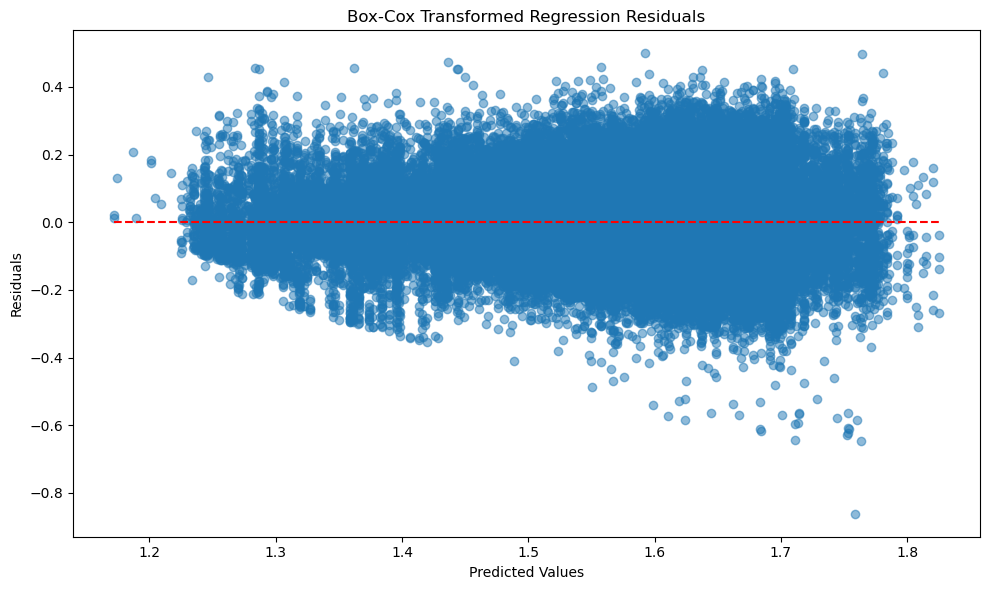

In [10]:
# Feature matrix (X) and target vector (y)
X = all_um_data[['Gender', 'true_age', 'State_elevation', 'distance']]
y = all_um_data['mph']  # Use the original target variable

# Apply Box-Cox transformation to y
# Note: Box-Cox transformation requires all values to be positive
# Add a small constant if needed to make all values positive
# Shift to make all values positive if needed
y_positive = y + 1
y_boxcox, lam = boxcox(y_positive)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size=0.2, random_state=42)

# Train an XGBoost model (as an example) on the transformed target variable
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Predict on the test set
y_pred_boxcox = model.predict(X_test)

# Inverse Box-Cox transformation for predictions
y_pred = np.exp(y_pred_boxcox * lam) - 1

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_boxcox)
mae = mean_absolute_error(y_test, y_pred_boxcox)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plot the residuals and actual vs predicted values if needed
import matplotlib.pyplot as plt

residuals = y_test - y_pred_boxcox

plt.figure(figsize=(10, 6))

# Residuals Plot
plt.subplot()
plt.scatter(y_pred_boxcox, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred_boxcox), xmax=max(y_pred_boxcox), colors='red', linestyles='dashed')
plt.title('Box-Cox Transformed Regression Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [11]:

# Function to predict race pace and apply inverse Box-Cox transformation
def predict_race_pace_xgb(model, gender, age, elevation, distance, lam):
    input_data = np.array([[gender, age, elevation, distance]])
    predicted_boxcox = model.predict(input_data)
    if lam == 0:
        predicted_mph = np.exp(predicted_boxcox)
    else:
        predicted_mph = (np.exp(np.log(lam * predicted_boxcox + 1) / lam)) - 1
    return predicted_mph[0]

# Example input values
gender = 1
age = 20
elevation = 5680
distance = 2

# Predict race pace
predicted_race_pace = predict_race_pace_xgb(model, gender, age, elevation, distance, lam)
print(f'Predicted Race Pace: {predicted_race_pace:.2f} mph')


Predicted Race Pace: 4.12 mph


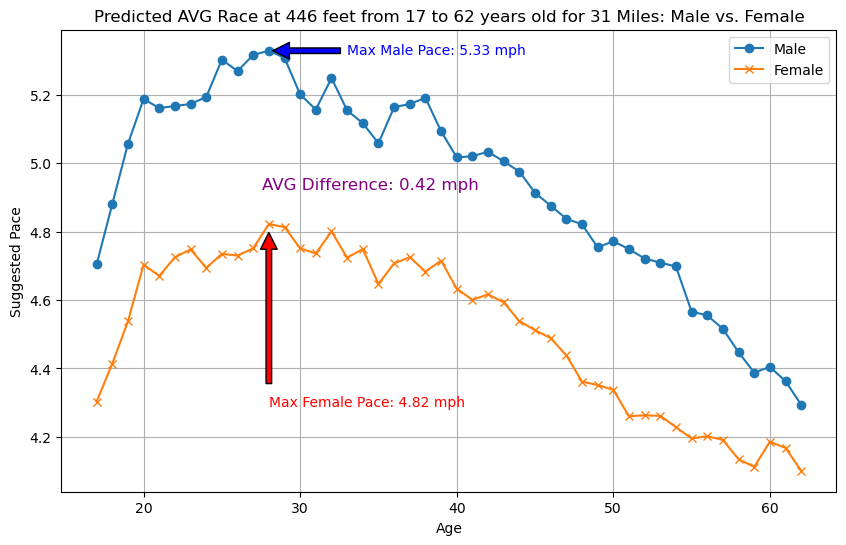

In [12]:
ages = range(17,63)
elevations = 446
distances = 31
predictions_male = [predict_race_pace_xgb(model, 1, age, elevations, distances, lam)for age in ages]
predictions_female = [predict_race_pace_xgb(model, 0, age, elevations, distances, lam)for age in ages]

average_pace_male = np.mean(predictions_male)
average_pace_female = np.mean(predictions_female)
pace_difference = average_pace_male - average_pace_female

max_pace_male = np.max(predictions_male)
max_pace_female = np.max(predictions_female)

midpoint_x = (ages[-1] + ages[0]) / 2 - 5
midpoint_y = (max(average_pace_male, average_pace_female) + min(average_pace_male, average_pace_female)) / 2 + 0.2




plt.figure(figsize=(10, 6)) 
plt.plot(ages, predictions_male, label='Male', linestyle='-', marker='o') 
plt.plot(ages, predictions_female, label='Female', linestyle='-', marker='x') 
plt.text(midpoint_x, midpoint_y, f'AVG Difference: {pace_difference:.2f} mph', fontsize=12, color='purple', ha='center')

max_age_male = ages[np.argmax(predictions_male)]
max_age_female = ages[np.argmax(predictions_female)]

plt.annotate(f'Max Male Pace: {max_pace_male:.2f} mph', xy=(max_age_male, max_pace_male), xytext=(max_age_male + 5, max_pace_male), arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10, color='blue', ha='left', va='center')
plt.annotate(f'Max Female Pace: {max_pace_female:.2f} mph', xy=(max_age_female, max_pace_female), xytext=(max_age_female, max_pace_female - 0.5), arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red', verticalalignment='top')


plt.xlabel('Age') 
plt.ylabel('Suggested Pace') 
plt.title('Predicted AVG Race at 446 feet from 17 to 62 years old for 31 Miles: Male vs. Female') 
plt.legend()
plt.grid(True) 
plt.show()

Key Points from the Graph:

    Age Range: The x-axis represents ages from 17 to 62 years.

    Race Pace: The y-axis indicates the race pace in miles per hour (mph).

    Lines:

        The blue line with circles represents the race pace for males.

        The orange line with crosses represents the race pace for females.

    Max Race Pace:

        Males: The peak race pace is 5.33 mph, marked by a blue arrow around age 30.

        Females: The peak race pace is 4.82 mph, indicated by a red arrow around age 30.

    Average Difference: There's a text annotation in purple that shows the difference between the average male and female paces, which is 0.42 mph.

Interpretation:

    Trends with Age: Both males and females reach their peak race pace around age 30 and experience a decline as they age. This is typical in endurance activities as performance often decreases with age.

    Gender Differences: Males consistently have a higher race pace compared to females, which is a common observation due to physiological differences.

    Average Difference: The average difference in race pace between males and females is 0.42 mph, with males generally being faster.

    Elevation Impact: The elevation of 446 feet is considered low to moderate, so its impact on race pace is likely minimal compared to higher elevations.

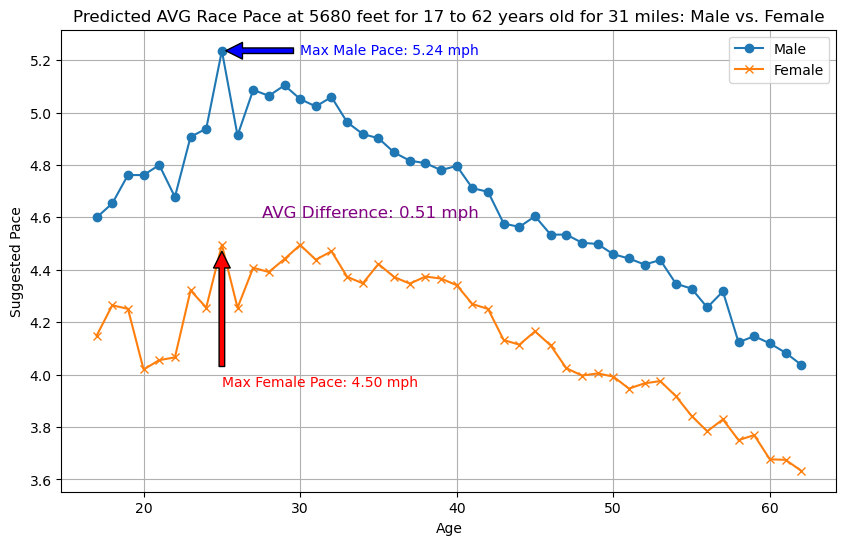

In [13]:
ages2 = range(17,63)
elevation2 = 5680
distance2 = 31
predictions_male2 = [predict_race_pace_xgb(model, 1, age, elevation2, distance2, lam)for age in ages2]
predictions_female2 = [predict_race_pace_xgb(model, 0, age, elevation2, distance2, lam)for age in ages2]

average_pace_male2 = np.mean(predictions_male2)
average_pace_female2 = np.mean(predictions_female2)
pace_difference2 = average_pace_male2 - average_pace_female2

max_pace_male2 = np.max(predictions_male2)
max_pace_female2 = np.max(predictions_female2)

midpoint_x2 = (ages2[-1] + ages2[0]) / 2 - 5
midpoint_y2 = (max(average_pace_male2, average_pace_female2) + min(average_pace_male2, average_pace_female2)) / 2 + 0.2

plt.figure(figsize=(10, 6)) 
plt.plot(ages2, predictions_male2, label='Male', linestyle='-', marker='o') 
plt.plot(ages2, predictions_female2, label='Female', linestyle='-', marker='x') 
plt.text(midpoint_x2, midpoint_y2, f'AVG Difference: {pace_difference2:.2f} mph', fontsize=12, color='purple', ha='center')

max_age_male2 = ages2[np.argmax(predictions_male2)]
max_age_female2 = ages2[np.argmax(predictions_female2)]

plt.annotate(f'Max Male Pace: {max_pace_male2:.2f} mph', xy=(max_age_male2, max_pace_male2), xytext=(max_age_male2 + 5, max_pace_male2), arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10, color='blue', ha='left', va='center')
plt.annotate(f'Max Female Pace: {max_pace_female2:.2f} mph', xy=(max_age_female2, max_pace_female2), xytext=(max_age_female2, max_pace_female2 - 0.5), arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red', verticalalignment='top')

plt.xlabel('Age') 
plt.ylabel('Suggested Pace') 
plt.title('Predicted AVG Race Pace at 5680 feet for 17 to 62 years old for 31 miles: Male vs. Female') 
plt.legend() 
plt.grid(True) 
plt.show()

Key Points from the Graph:

    Max Male Pace: The maximum race pace for males is 5.24 mph. This is indicated by a blue arrow pointing to the highest point on the male (blue) line.

    Max Female Pace: The maximum race pace for females is 4.50 mph. This is marked by a red arrow pointing to the highest point on the female (red) line.

    Average Difference: The text in purple annotates the average difference in race pace between males and females. The difference is 0.51 mph.

    Trends: Both male and female race paces generally decline with increasing age. However, males consistently show a higher pace compared to females across all ages.

Interpretation:

    Performance Decline with Age: The graph demonstrates a common trend in endurance sports where performance, measured by race pace, tends to decline as athletes age. This decline is visible for both genders.

    Gender Differences: Males generally maintain a faster average race pace compared to females across the age spectrum. This is a consistent finding in endurance sports due to physiological differences.

    Maximum Performance Ages: The graph identifies the ages at which males and females reach their peak performance for this specific elevation and distance. For males, the peak is around age 17, while for females, it occurs around age 17 as well.

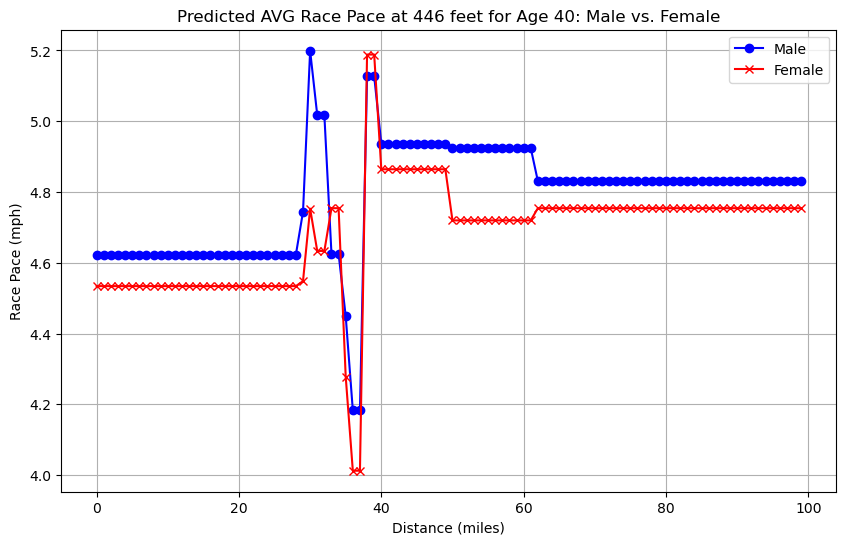

In [ ]:

# Define the distance range
distances = np.arange(0, 100, 1)  # 0 to 100 miles in increments of 1 mile

# Choose specific age and elevation
chosen_age = 40
chosen_elevation = 446  # Example elevation

# Generate predictions for males and females across distances
predictions_male = [predict_race_pace_xgb(model, 1, chosen_age, chosen_elevation, distance, lam) for distance in distances]
predictions_female = [predict_race_pace_xgb(model, 0, chosen_age, chosen_elevation, distance, lam) for distance in distances]

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot race pace for males
plt.plot(df['balance'], df['age/dow'], label='Male', linestyle='-', marker='o', color='b')

# Plot race pace for females
plt.plot(distances, predictions_female, label='Female', linestyle='-', marker='x', color='r')

# Customize the plot
plt.xlabel('Distance (miles)')
plt.ylabel('Race Pace (mph)')
plt.title(f'Predicted AVG Race Pace at {chosen_elevation} feet for Age {chosen_age}: Male vs. Female')
plt.legend()
plt.grid(True)
plt.show()


This chart shows that we cannot accurately predict data below 26 miles.  We do not have enough data to support accurate analysis of how runners perform from 1 - 26 miles.  Most races for ultra marathons are from 26 to 100 miles.  That shows more accurate predictions.

From my box cox transformation for my graphs from a high altitude and a low altitude, the graphs show a similar declining trend with age.  The difference in race pace between genders is slightly more pronounced with lower elevation.  The comparison helps us understand the impace of elevation on race performance, showing tha tmales generally perform better than females and both experience a delicine in pace with age.

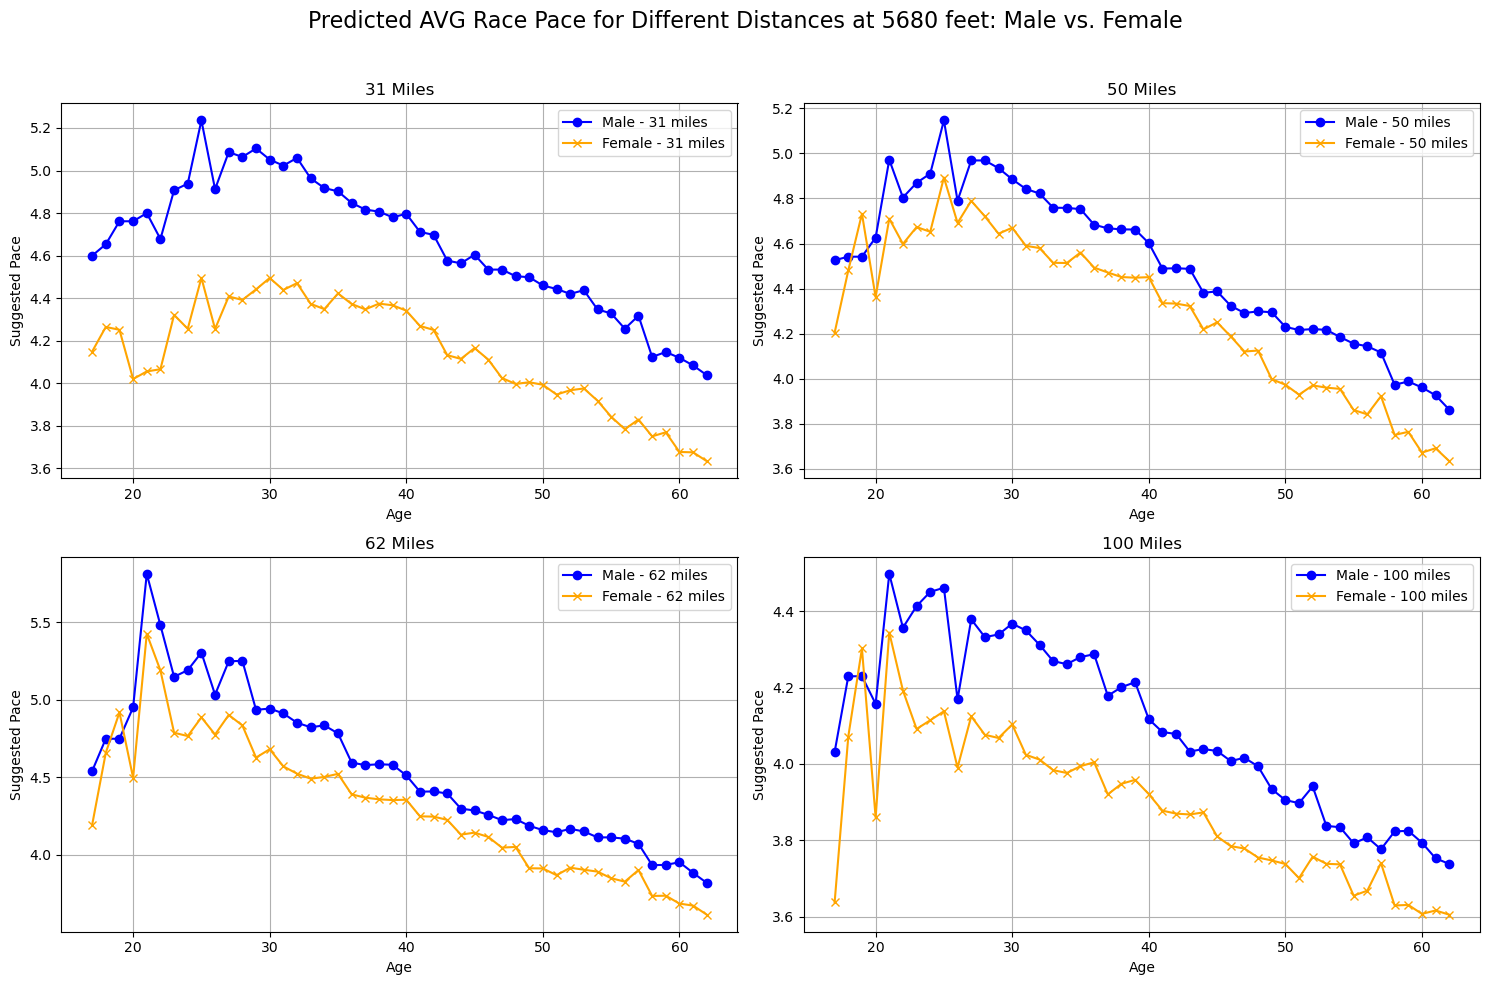

In [15]:


# Define the distances and age range
new_distances = [31, 50, 62, 100]
new_ages = np.arange(17, 63)
new_elevation = 5680  # Keep the elevation constant for comparison

# Generate predictions for each distance and gender
predictions_male3 = {distance: [predict_race_pace_xgb(model, 1, age, new_elevation, distance, lam) for age in new_ages] for distance in new_distances}
predictions_female3 = {distance: [predict_race_pace_xgb(model, 0, age, new_elevation, distance, lam) for age in new_ages] for distance in new_distances}

fig, axs = plt.subplots(2, 2, figsize=(15, 10)) # 2 rows, 2 columns

axs = axs.flatten()

for i, distance in enumerate(new_distances):
    axs[i].plot(new_ages, predictions_male3[distance], label=f'Male - {distance} miles', linestyle='-', marker='o', color='blue')
    axs[i].plot(new_ages, predictions_female3[distance], label=f'Female - {distance} miles', linestyle='-', marker='x', color='orange')
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel('Suggested Pace')
    axs[i].set_title(f'{distance} Miles')
    axs[i].legend()
    axs[i].grid(True)
    
fig.suptitle('Predicted AVG Race Pace for Different Distances at 5680 feet: Male vs. Female', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

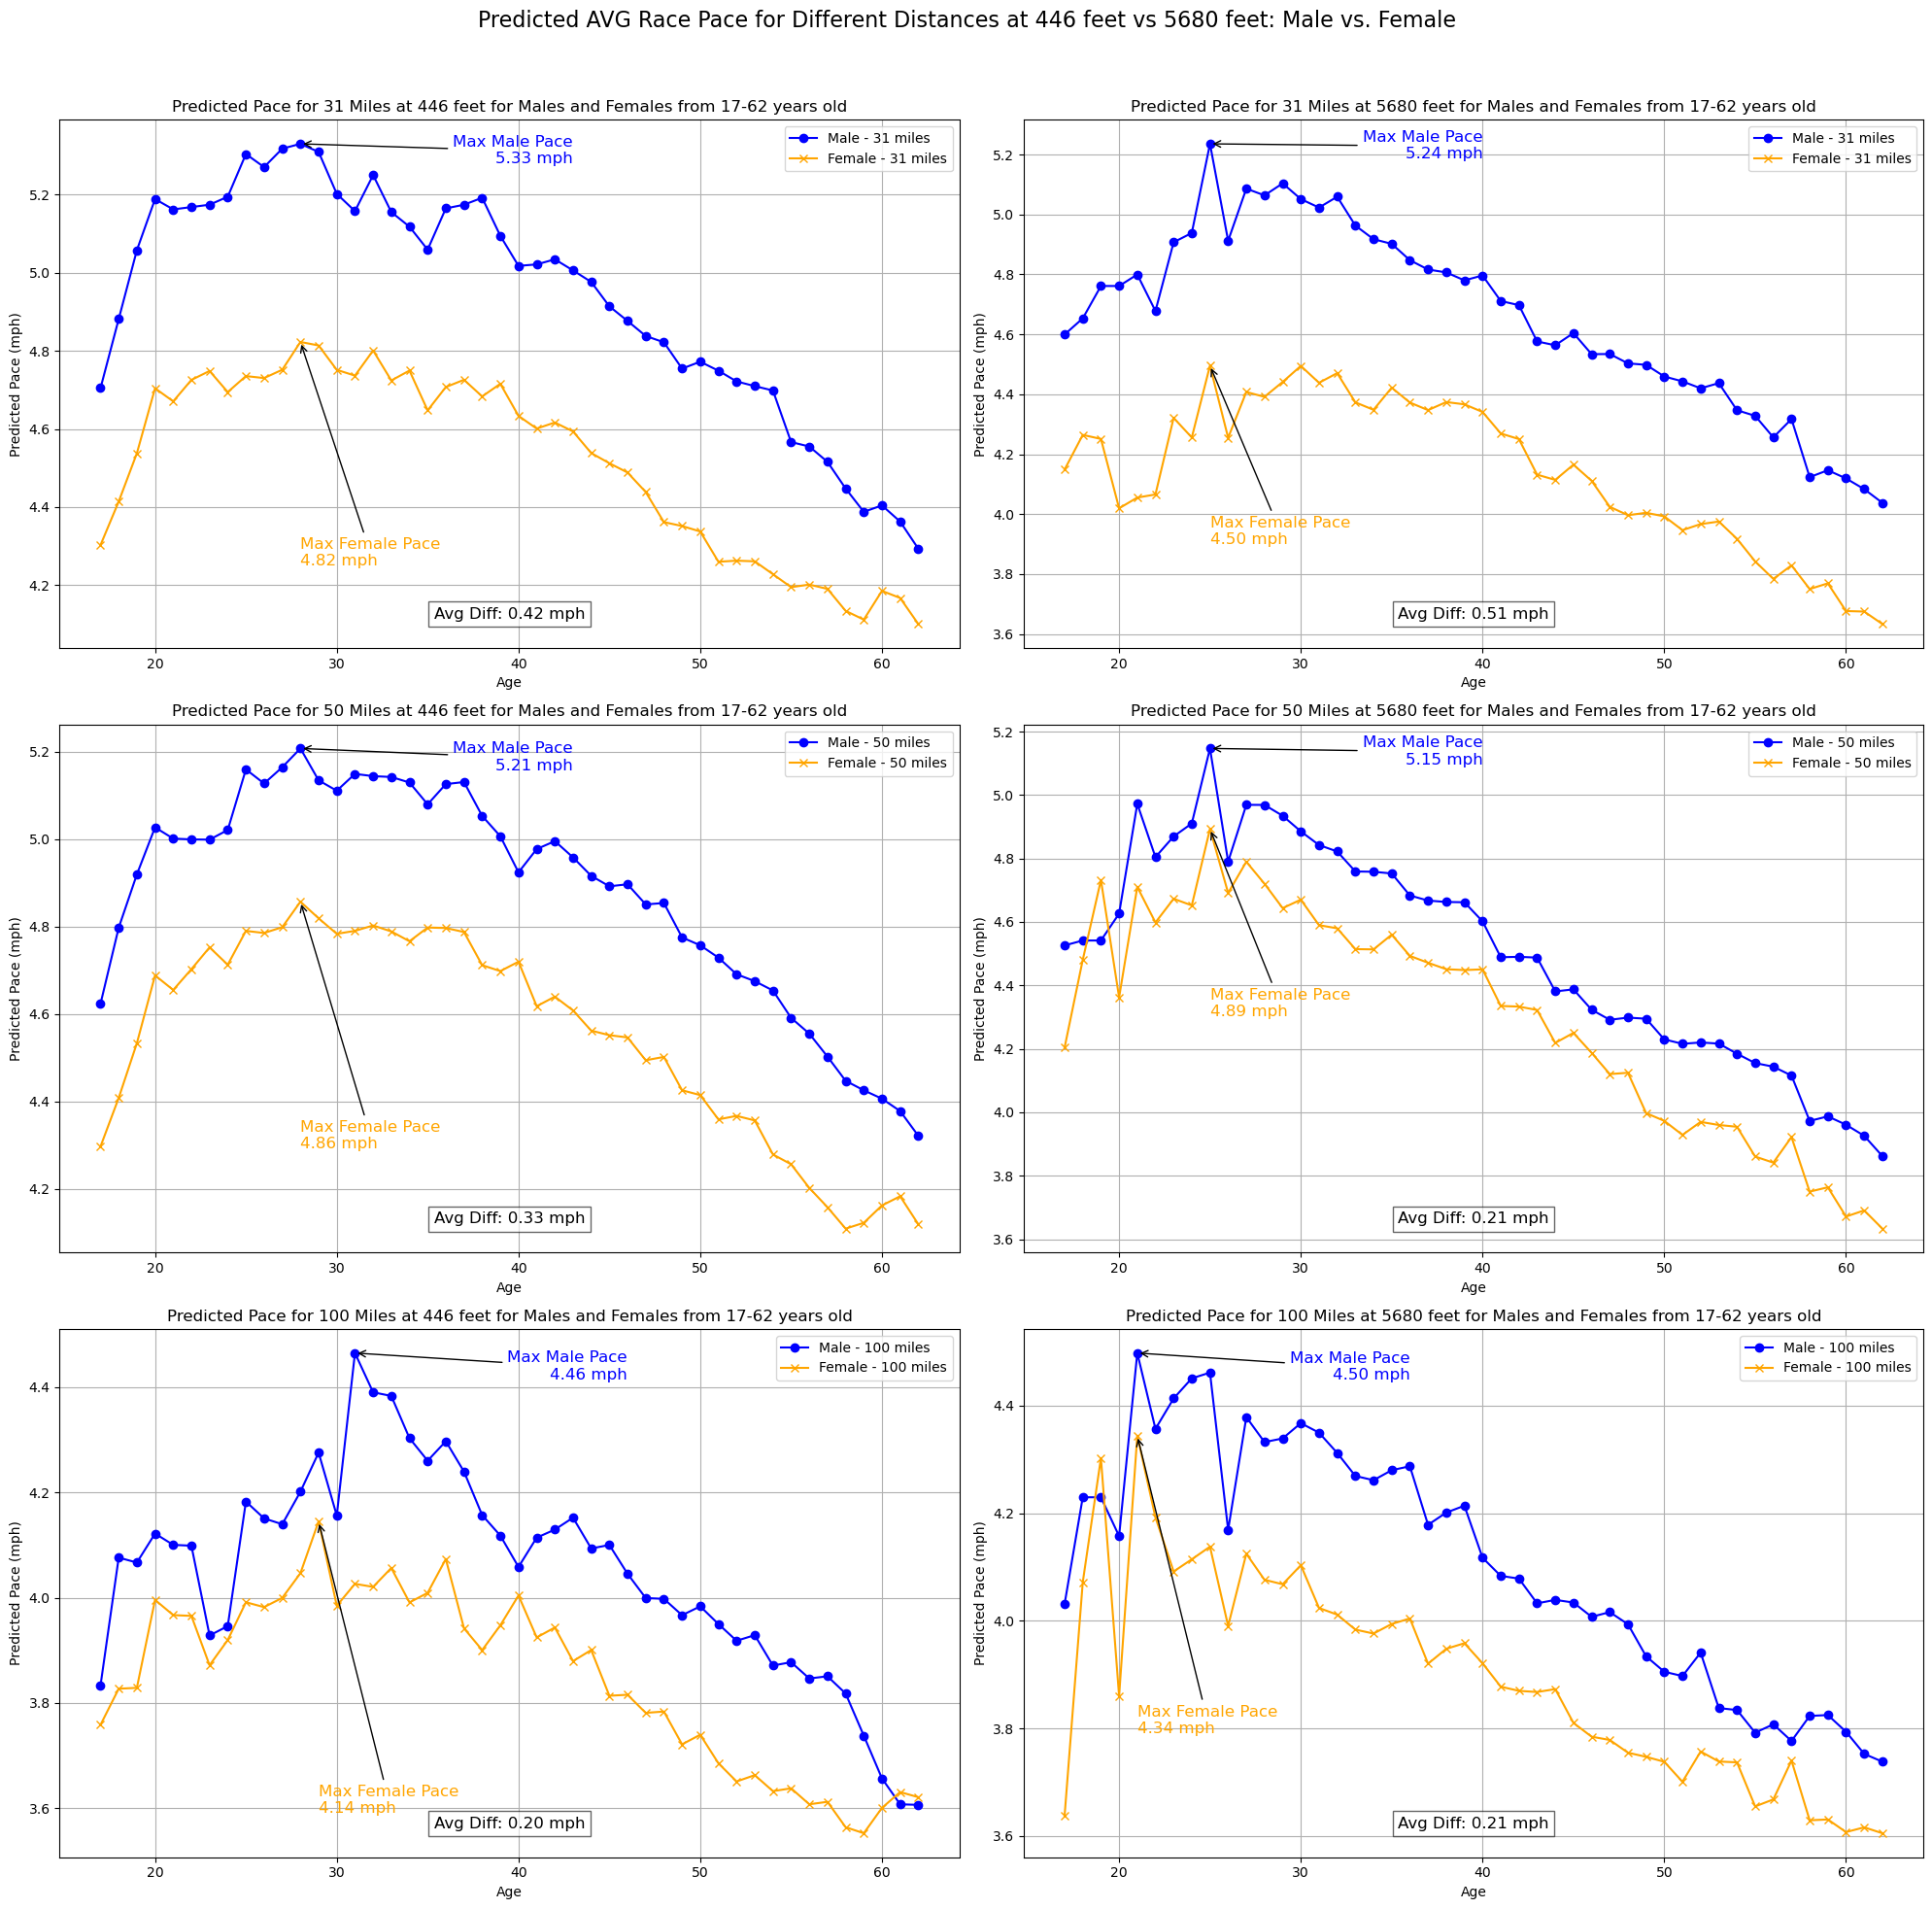

In [16]:


# Define the distances and age range
distances = [31, 50, 100]
ages = np.arange(17, 63)
elevations = [446, 5680]

# Generate predictions for each distance, elevation, and gender
predictions = {
    elevation: {
        'male': {distance: [predict_race_pace_xgb(model, 1, age, elevation, distance, lam) for age in ages] for distance in distances},
        'female': {distance: [predict_race_pace_xgb(model, 0, age, elevation, distance, lam) for age in ages] for distance in distances}
    }
    for elevation in elevations
}

# Calculate the difference in average pace between males and females
pace_diff = {
    elevation: {
        distance: np.mean(predictions[elevation]['male'][distance]) - np.mean(predictions[elevation]['female'][distance])
        for distance in distances
    }
    for elevation in elevations
}

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))  # 3 rows, 2 columns

# Plot each distance and elevation in separate subplots
for j, elevation in enumerate(elevations):
    for i, distance in enumerate(distances):
        row = i
        col = j
        
        # Plot predictions for males and females
        axs[row, col].plot(ages, predictions[elevation]['male'][distance], label=f'Male - {distance} miles', linestyle='-', marker='o', color='blue')
        axs[row, col].plot(ages, predictions[elevation]['female'][distance], label=f'Female - {distance} miles', linestyle='-', marker='x', color='orange')
        
        # Annotate the average pace difference on the plot
        avg_diff = pace_diff[elevation][distance]
        axs[row, col].text(0.5, 0.05, f'Avg Diff: {avg_diff:.2f} mph', 
                           transform=axs[row, col].transAxes, fontsize=12,
                           verticalalignment='bottom', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.6))
        
        # Find max race pace for males and females
        max_male_idx = np.argmax(predictions[elevation]['male'][distance])
        max_female_idx = np.argmax(predictions[elevation]['female'][distance])
        
        max_male_age = ages[max_male_idx]
        max_male_pace = predictions[elevation]['male'][distance][max_male_idx]
        
        max_female_age = ages[max_female_idx]
        max_female_pace = predictions[elevation]['female'][distance][max_female_idx]
        
        # Add arrows pointing to the max race pace
        axs[row, col].annotate(f'Max Male Pace\n{max_male_pace:.2f} mph', xy=(max_male_age, max_male_pace), xytext=(max_male_age + 15, max_male_pace - 0.05),
                               arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=12, color='blue', horizontalalignment='right')
        axs[row, col].annotate(f'Max Female Pace\n{max_female_pace:.2f} mph', xy=(max_female_age, max_female_pace), xytext=(max_female_age, max_female_pace - 0.5),
                               arrowprops=dict(facecolor='orange', arrowstyle='->'), fontsize=12, color='orange', verticalalignment='top')
        
        # Set labels and titles
        axs[row, col].set_xlabel('Age')
        axs[row, col].set_ylabel('Predicted Pace (mph)')
        axs[row, col].set_title(f'Predicted Pace for {distance} Miles at {elevation} feet for Males and Females from 17-62 years old')
        axs[row, col].legend()
        axs[row, col].grid(True)

# Add a main title for the entire figure
fig.suptitle('Predicted AVG Race Pace for Different Distances at 446 feet vs 5680 feet: Male vs. Female', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


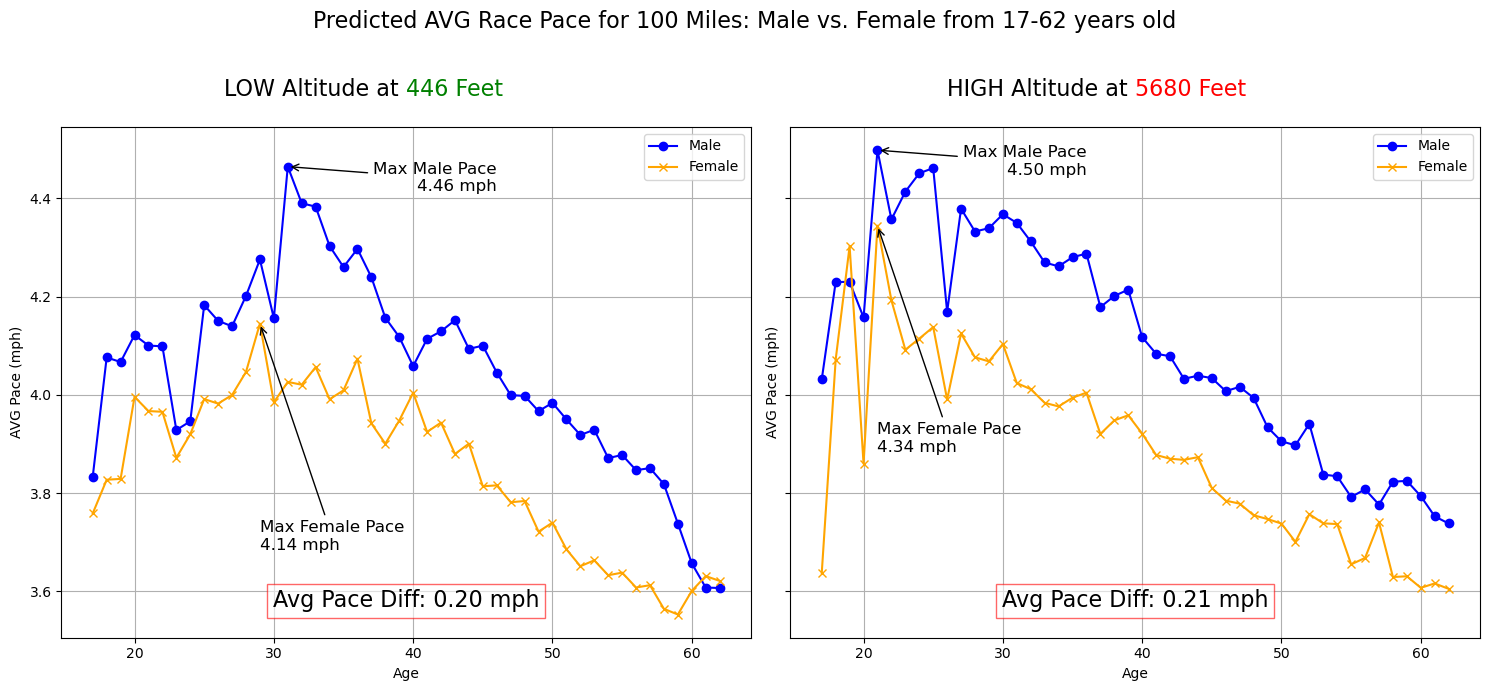

In [37]:

# Define the age range and elevations
ages = np.arange(17, 63)
elevations = [446, 5680]

# Define the specific distance to plot
specific_distance = 100  # Change this to 50 or 100 for other distances

# Generate predictions for each elevation and gender for the specific distance
predictions = {
    elevation: {
        'male': [predict_race_pace_xgb(model, 1, age, elevation, specific_distance, lam) for age in ages],
        'female': [predict_race_pace_xgb(model, 0, age, elevation, specific_distance, lam) for age in ages]
    }
    for elevation in elevations
}

# Calculate the difference in average pace between males and females for the specific distance
pace_diff = {
    elevation: np.mean(predictions[elevation]['male']) - np.mean(predictions[elevation]['female'])
    for elevation in elevations
}

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)  # 1 row, 2 columns

# Plot each elevation in separate subplots
for j, elevation in enumerate(elevations):
    col = j
    
    # Plot predictions for males and females
    axs[col].plot(ages, predictions[elevation]['male'], label='Male', linestyle='-', marker='o', color='blue')
    axs[col].plot(ages, predictions[elevation]['female'], label='Female', linestyle='-', marker='x', color='orange')
    
    # Annotate the average pace difference on the plot
    avg_diff = pace_diff[elevation]
    axs[col].text(0.5, 0.05, f'Avg Pace Diff: {avg_diff:.2f} mph', 
                  transform=axs[col].transAxes, fontsize=16,
                  verticalalignment='bottom', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='red'))
    
    # Find max race pace for males and females
    max_male_idx = np.argmax(predictions[elevation]['male'])
    max_female_idx = np.argmax(predictions[elevation]['female'])
    
    max_male_age = ages[max_male_idx]
    max_male_pace = predictions[elevation]['male'][max_male_idx]
    
    max_female_age = ages[max_female_idx]
    max_female_pace = predictions[elevation]['female'][max_female_idx]
    
    # Add arrows pointing to the max race pace
    axs[col].annotate(f'Max Male Pace\n{max_male_pace:.2f} mph', xy=(max_male_age, max_male_pace), xytext=(max_male_age + 15, max_male_pace - 0.05),
                      arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=12, color='black', horizontalalignment='right')
    axs[col].annotate(f'Max Female Pace\n{max_female_pace:.2f} mph', xy=(max_female_age, max_female_pace), xytext=(max_female_age, max_female_pace - 0.4),
                      arrowprops=dict(facecolor='orange', arrowstyle='->'), fontsize=12, color='black', verticalalignment='top')
    
    # Set labels and titles
    axs[col].set_xlabel('Age')
    axs[col].set_ylabel('AVG Pace (mph)')

    # Adding colored title text using annotate
    if elevation == 446:
        title = axs[col].annotate(
            'LOW Altitude at ', xy=(0.5, 1.05), xycoords='axes fraction',
            ha='right', va='bottom', fontsize=16, color='black'
        )
        title = axs[col].annotate(
            '446 Feet', xy=(0.5, 1.05), xycoords='axes fraction',
            ha='left', va='bottom', fontsize=16, color='green'
        )
    elif elevation == 5680:
        title = axs[col].annotate(
            'HIGH Altitude at ', xy=(0.5, 1.05), xycoords='axes fraction',
            ha='right', va='bottom', fontsize=16, color='black'
        )
        title = axs[col].annotate(
            '5680 Feet', xy=(0.5, 1.05), xycoords='axes fraction',
            ha='left', va='bottom', fontsize=16, color='red'
        )
    
  
    axs[col].legend()
    axs[col].grid(True)

# Add a main title for the entire figure
fig.suptitle(f'Predicted AVG Race Pace for {specific_distance} Miles: Male vs. Female from 17-62 years old', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


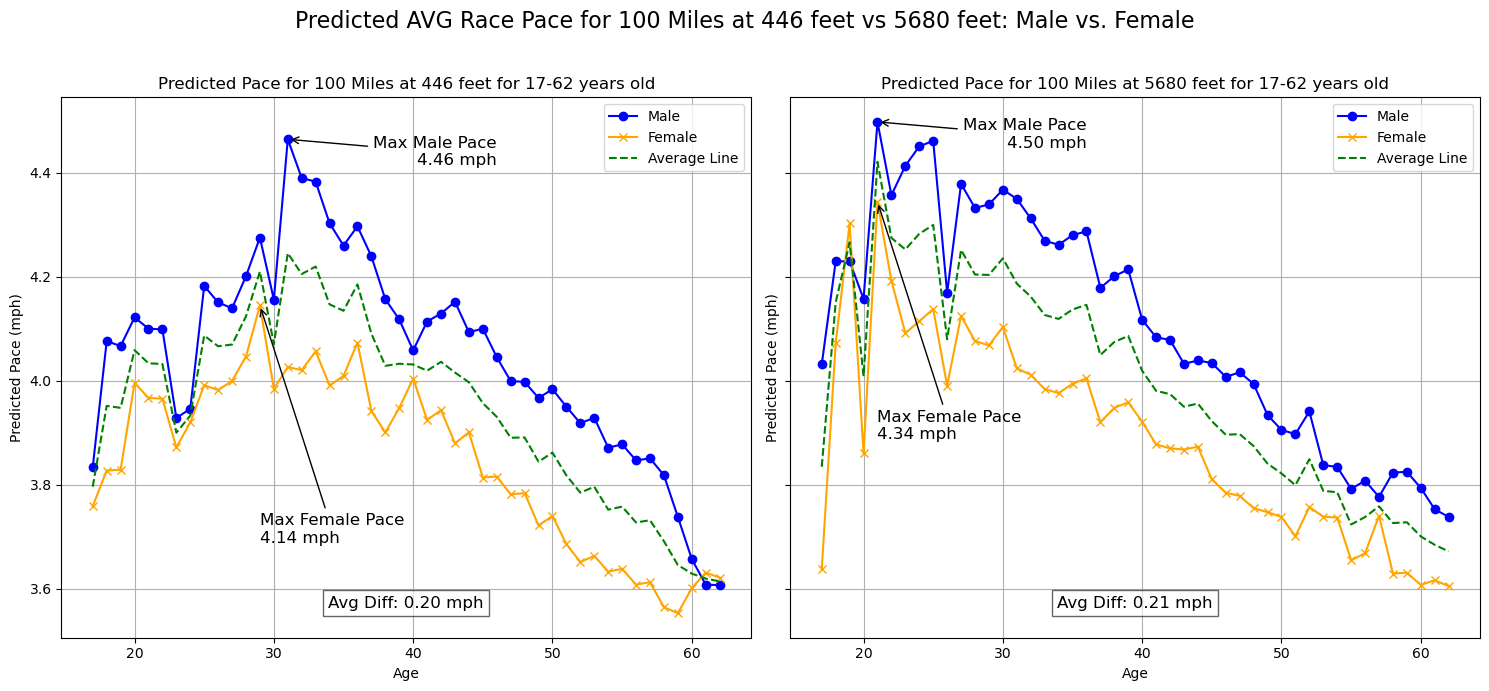

In [18]:


# Define the age range and elevations
ages = np.arange(17, 63)
elevations = [446, 5680]

# Define the specific distance to plot
specific_distance = 100  # Change this to 50 or 100 for other distances

# Generate predictions for each elevation and gender for the specific distance
predictions = {
    elevation: {
        'male': [predict_race_pace_xgb(model, 1, age, elevation, specific_distance, lam) for age in ages],
        'female': [predict_race_pace_xgb(model, 0, age, elevation, specific_distance, lam) for age in ages]
    }
    for elevation in elevations
}

# Calculate the difference in average pace between males and females for each age and elevation
pace_diff = {
    elevation: [predictions[elevation]['male'][i] - predictions[elevation]['female'][i] for i in range(len(ages))]
    for elevation in elevations
}

# Calculate the average line between male and female lines
average_line = {
    elevation: [(predictions[elevation]['male'][i] + predictions[elevation]['female'][i]) / 2 for i in range(len(ages))]
    for elevation in elevations
}

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)  # 1 row, 2 columns

# Plot each elevation in separate subplots
for j, elevation in enumerate(elevations):
    col = j
    
    # Plot predictions for males and females
    axs[col].plot(ages, predictions[elevation]['male'], label='Male', linestyle='-', marker='o', color='blue')
    axs[col].plot(ages, predictions[elevation]['female'], label='Female', linestyle='-', marker='x', color='orange')
    
    # Plot the average line between male and female
    axs[col].plot(ages, average_line[elevation], label='Average Line', linestyle='--', color='green')
    
    # Annotate the average pace difference on the plot
    avg_diff = np.mean(pace_diff[elevation])
    axs[col].text(0.5, 0.05, f'Avg Diff: {avg_diff:.2f} mph', 
                  transform=axs[col].transAxes, fontsize=12,
                  verticalalignment='bottom', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.6))
    
    # Find max race pace for males and females
    max_male_idx = np.argmax(predictions[elevation]['male'])
    max_female_idx = np.argmax(predictions[elevation]['female'])
    
    max_male_age = ages[max_male_idx]
    max_male_pace = predictions[elevation]['male'][max_male_idx]
    
    max_female_age = ages[max_female_idx]
    max_female_pace = predictions[elevation]['female'][max_female_idx]
    
    # Add arrows pointing to the max race pace
    axs[col].annotate(f'Max Male Pace\n{max_male_pace:.2f} mph', xy=(max_male_age, max_male_pace), xytext=(max_male_age + 15, max_male_pace - 0.05),
                      arrowprops=dict(facecolor='blue', arrowstyle='->'), fontsize=12, color='black', horizontalalignment='right')
    axs[col].annotate(f'Max Female Pace\n{max_female_pace:.2f} mph', xy=(max_female_age, max_female_pace), xytext=(max_female_age, max_female_pace - 0.4),
                      arrowprops=dict(facecolor='orange', arrowstyle='->'), fontsize=12, color='black', verticalalignment='top')
    
    # Set labels and titles
    axs[col].set_xlabel('Age')
    axs[col].set_ylabel('Predicted Pace (mph)')
    axs[col].set_title(f'Predicted Pace for {specific_distance} Miles at {elevation} feet for 17-62 years old')
    axs[col].legend()
    axs[col].grid(True)

# Add a main title for the entire figure
fig.suptitle(f'Predicted AVG Race Pace for {specific_distance} Miles at 446 feet vs 5680 feet: Male vs. Female', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
